In [19]:
import os

import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf
import tensorflow.keras.layers as layers
from tensorflow.keras.models import Sequential

import cv2 as cv
import matplotlib.pyplot as plt

### Reading data

In [20]:
def read_dataset(path, size=64):
    ds = tf.keras.utils.image_dataset_from_directory(
        path,
        label_mode='categorical',
        shuffle=True,
        seed=42,
        image_size=(size, size),
    )
    
    X, y = zip(*ds)
    X = np.concatenate(X)
    y = np.concatenate(y)
    
    return X, y

In [21]:
train_X, train_y = read_dataset('data/train/')
test_X, test_y = read_dataset('data/test/')
labels = sorted(os.listdir('data/train'))

Found 10019 files belonging to 10 classes.
Found 500 files belonging to 10 classes.


### Gray

In [4]:
def cvt_to_gray(images):
    gray_images = []
    for rgb_image in images:
        gray_image = cv.cvtColor(rgb_image, cv.COLOR_RGB2GRAY)
        gray_images.append(gray_image)
    gray_images = np.array(gray_images)
    gray_images = gray_images[..., np.newaxis]
    return gray_images

In [133]:
gray_train_X = cvt_to_gray(train_X)
gray_test_X = cvt_to_gray(test_X)
gray_train_X.shape, gray_test_X.shape

((10019, 64, 64, 1), (353, 64, 64, 1))

In [171]:
gray_train_X = np.abs(gray_train_X)
gray_test_X = np.abs(gray_test_X)

### Gradients

In [22]:
def get_gradients(rgb_image):
    gray_image = cv.cvtColor(rgb_image, cv.COLOR_RGB2GRAY) / 256
    
    sobelx = cv.Sobel(gray_image, cv.CV_64F,1,0,ksize=3)
    sobely = cv.Sobel(gray_image, cv.CV_64F,0,1,ksize=3)
    sobelxy = cv.Sobel(gray_image, cv.CV_64F,1,1,ksize=3)
    # laplacian = cv.Laplacian(gray_image, cv.CV_64F)
    
    return [sobelx, sobely, sobelxy]

In [23]:
def cvt_to_gradients(images):
    grad_images = []
    for rgb_image in images:
        gradients = get_gradients(rgb_image)
        grad_images.append(gradients)
    grad_images = np.array(grad_images)
    grad_images = np.transpose(grad_images, (0, 2, 3, 1))
    return grad_images

In [24]:
grad_train_X = cvt_to_gradients(train_X)
grad_test_X = cvt_to_gradients(test_X)
grad_train_X.shape, grad_test_X.shape

bin_grad_train_X = np.abs(grad_train_X)
bin_grad_test_X = np.abs(grad_test_X)

In [8]:
np.max(grad_train_X), np.min(grad_train_X)

(3.848439373075962, -3.870525425300002)

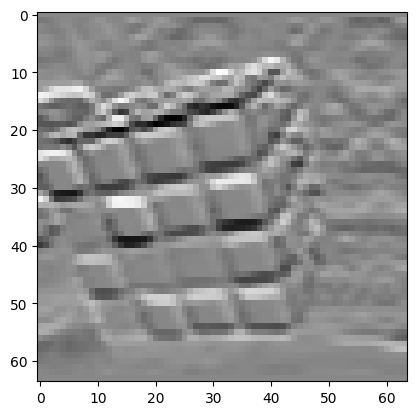

In [140]:
plt.imshow(grad_train_X[402, ..., 1], 'gray')

In [25]:
model = Sequential([
    layers.Input(shape=(None, None, 3)),
    layers.Resizing(64, 64),
    # layers.RandomFlip('horizontal'),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(10, activation='softmax'),
])

In [26]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_2 (Resizing)       (None, 64, 64, 3)         0         
                                                                 
 conv2d_8 (Conv2D)           (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 31, 31, 32)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 12, 12, 128)      

In [27]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [28]:
history = model.fit(bin_grad_train_X, train_y, validation_data=(bin_grad_test_X, test_y), epochs=40, batch_size=64)

Epoch 1/40
157/157 [==============================] - 2s 11ms/step - loss: 1.9545 - accuracy: 0.2610 - val_loss: 1.5485 - val_accuracy: 0.4160
Epoch 2/40
157/157 [==============================] - 2s 10ms/step - loss: 1.1125 - accuracy: 0.6040 - val_loss: 1.5623 - val_accuracy: 0.4800
Epoch 3/40
157/157 [==============================] - 2s 10ms/step - loss: 0.6817 - accuracy: 0.7610 - val_loss: 1.3260 - val_accuracy: 0.5660
Epoch 4/40
157/157 [==============================] - 2s 10ms/step - loss: 0.4121 - accuracy: 0.8578 - val_loss: 1.8123 - val_accuracy: 0.5640
Epoch 5/40
157/157 [==============================] - 2s 10ms/step - loss: 0.2910 - accuracy: 0.9103 - val_loss: 1.3938 - val_accuracy: 0.6140
Epoch 6/40
157/157 [==============================] - 2s 10ms/step - loss: 0.1640 - accuracy: 0.9499 - val_loss: 1.7181 - val_accuracy: 0.6340
Epoch 7/40
157/157 [==============================] - 2s 10ms/step - loss: 0.1296 - accuracy: 0.9614 - val_loss: 2.1737 - val_accuracy: 0.6520

16/16 [==============================] - 0s 12ms/step
              precision    recall  f1-score   support

           0       0.44      0.38      0.41        50
           1       0.58      0.78      0.67        50
           2       0.50      0.48      0.49        50
           3       0.78      0.80      0.79        50
           4       0.53      0.62      0.57        50
           5       1.00      0.84      0.91        50
           6       0.70      0.78      0.74        50
           7       0.97      0.78      0.87        50
           8       0.54      0.40      0.46        50
           9       0.75      0.86      0.80        50

    accuracy                           0.67       500
   macro avg       0.68      0.67      0.67       500
weighted avg       0.68      0.67      0.67       500



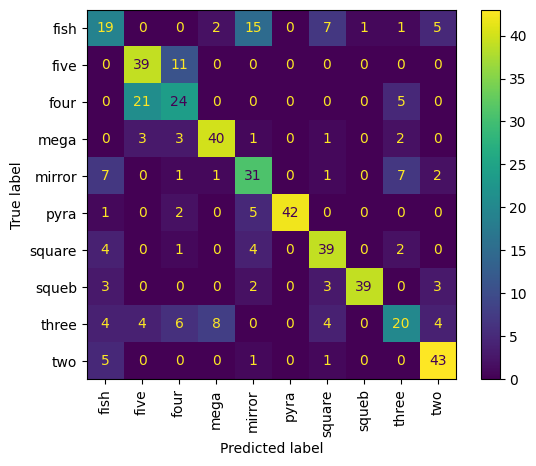

In [29]:
predictions = model.predict(bin_grad_test_X)
true_classes = np.argmax(test_y, axis=1)
predicted_classes = np.argmax(predictions, axis=1)

report = classification_report(true_classes, predicted_classes)
cm = confusion_matrix(true_classes, predicted_classes)

print(report)
ConfusionMatrixDisplay.from_predictions(
    true_classes, 
    predicted_classes, 
    display_labels=labels, 
    xticks_rotation='vertical',
);